In [86]:
from argparse import ArgumentParser, Namespace
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

In [87]:
sys.path.append(str(Path(".").resolve().parent))

In [88]:
IS_INTERACTIVE = False
try:
    get_ipython()  # type: ignore
except NameError: pass
else: IS_INTERACTIVE = True
IS_INTERACTIVE

True

In [89]:
p = ArgumentParser()
p.add_argument("natural_language_stimulus_path", type=Path)

_StoreAction(option_strings=[], dest='natural_language_stimulus_path', nargs=None, const=None, default=None, type=<class 'pathlib.Path'>, choices=None, required=True, help=None, metavar=None)

In [90]:
if IS_INTERACTIVE:
    args = Namespace(natural_language_stimulus_path=Path("gillis2021/DKZ_1.pkl"))
else:
    args = p.parse_args()

---

In [91]:
with args.natural_language_stimulus_path.open("rb") as f:
    stim = pickle.load(f)

In [92]:
print("Num words:", len(stim.word_lengths))
print("Num candidates:", stim.p_word.shape[-1])

Num words: 2187
Num candidates: 10


Text(0.5, 0, 'Ground-truth word probability')

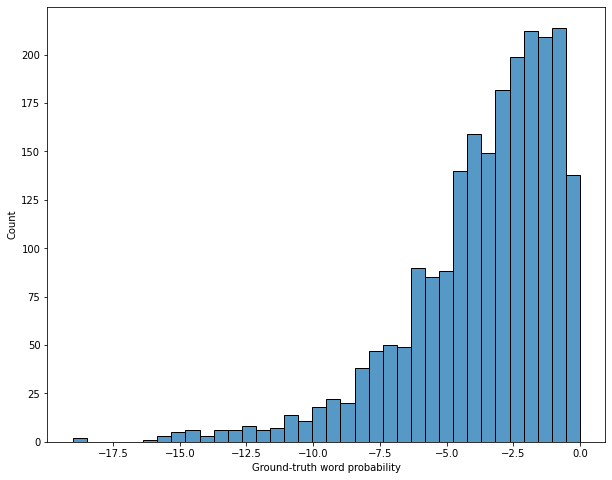

In [93]:
gt_word_probs = stim.p_word[:, 0].numpy()

plt.subplots(figsize=(10, 8))
sns.histplot(gt_word_probs)
plt.xlabel("Ground-truth word probability")

In [94]:
candidate_lengths = (stim.candidate_phonemes != stim.pad_phoneme_id).sum(dim=2)
gt_lengths, candidate_lengths = candidate_lengths[:, 0], candidate_lengths[:, 1:]
candidate_mean_lengths = candidate_lengths.float().mean(dim=1)

<AxesSubplot:title={'center':'Ground-truth candidate lengths (in phonemes)'}, ylabel='Count'>

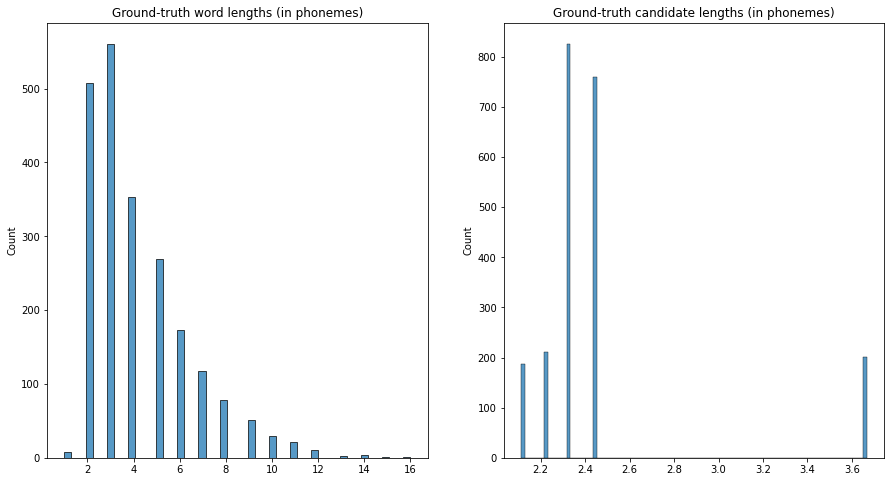

In [95]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.set_title("Ground-truth word lengths (in phonemes)")
ax2.set_title("Ground-truth candidate lengths (in phonemes)")

sns.histplot(gt_lengths.numpy(), ax=ax1)
sns.histplot(candidate_mean_lengths.numpy(), ax=ax2)

<AxesSubplot:title={'center':'Fraction of candidates which are incremental cohort competitors, by phoneme position'}, xlabel='phoneme', ylabel='is_competitor'>

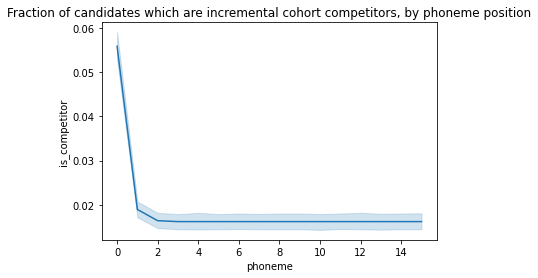

In [96]:
# For each candidate, is it a cohort competitor with ground truth?
max_num_phonemes = stim.candidate_phonemes.shape[2]
is_cohort_competitor = (stim.candidate_phonemes[:, 1:] == stim.candidate_phonemes[:, :1]).cumsum(dim=2) == torch.arange(1, max_num_phonemes + 1)

plt.title("Fraction of candidates which are incremental cohort competitors, by phoneme position")
sns.lineplot(data=pd.DataFrame(is_cohort_competitor.reshape(-1, max_num_phonemes).numpy()).melt(var_name="phoneme", value_name="is_competitor"),
             x="phoneme", y="is_competitor")

In [97]:
print("Percentage of words which have a candidate which is a cohort competitor for at least one phoneme:",
      is_cohort_competitor.any(dim=2).any(dim=1).float().mean().item() * 100)

Percentage of words which have a candidate which is a cohort competitor for at least one phoneme: 36.03109419345856
